<a href="https://colab.research.google.com/github/rahulkd/Deep_learning/blob/master/Mnist_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-03-18 19:01:27--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.200.123.104, 52.201.75.180, 52.203.53.176, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.200.123.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14910739 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  14.22M  7.13MB/s    in 2.0s    

2019-03-18 19:01:29 (7.13 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [14910739/14910739]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: ngrok                   
http://59c11377.ngrok.io


In [0]:
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
def read_dataset():
  
  (x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = tf.keras.datasets.mnist.load_data()
  return (x_train_orig,y_train_orig,x_test_orig,y_test_orig)

In [0]:
def convert_to_one_hot(labels,C):

    #C = tf.constant(C)
    one_hot_matrix = tf.one_hot(labels, C, axis=1)

    # Create the session
    sess = tf.Session()
    # Run the session
    one_hot = sess.run(one_hot_matrix)
    sess.close()

    return one_hot

0
number of training examples = 60000
number of test examples = 10000
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)


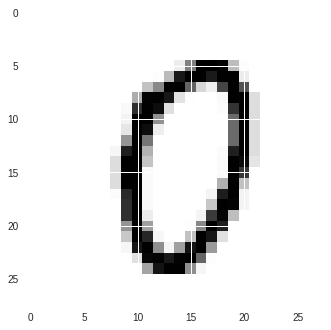

In [0]:
X_train_orig,Y_train_orig,X_test_orig,Y_test_org = read_dataset()

image_index = 1000 # You may select anything up to 60,000
print(Y_train_orig[image_index]) # The label is 8
plt.imshow(X_train_orig[image_index], cmap='Greys')

X_train_orig = X_train_orig.reshape(X_train_orig.shape[0],28,28,1)
X_test_orig = X_test_orig.reshape(X_test_orig.shape[0],28,28,1)

X_train = X_train_orig/255
X_test = X_test_orig/255

Y_train = convert_to_one_hot(Y_train_orig,10)
Y_test = convert_to_one_hot(Y_test_org,10)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

In [0]:
def random_mini_batches(X, Y, mini_batch_size):
    
    m = X.shape[0]                # number of training examples
    mini_batches = []
    #np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size)
    # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])

    return X, Y

In [0]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network 
    with tensorflow. The shapes are:
                        W1 : [4, 4, 1, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)
        
    W1 = tf.get_variable("W1",[4,4,1,8],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [0]:
## Implement the forward propagation 
def forward_propagation(X, parameters,keep_prob):

    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    ## 1st layer
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 2x2, stride 2, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    ##2nd layer
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    #MAXPOOL: window 2X2, stride 2, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    # FLATTEN
    P2_flatten = tf.contrib.layers.flatten(P2)
    
    FC1 = tf.contrib.layers.fully_connected(P2_flatten,128,activation_fn=tf.nn.relu)
    layer_drop = tf.nn.dropout(FC1, keep_prob)
    
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    output_layer = tf.contrib.layers.fully_connected(FC1,10,activation_fn = None)
    
    return output_layer

In [0]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    return cost

In [0]:
### ===== For tensorboard display ================== ###

summary_path = './log'
with tf.name_scope('performance'):

  ## Define the summaries
        
  # Whenever you need to record the loss, feed the mean loss to this placeholder
  tf_loss = tf.placeholder(tf.float32, shape=None, name='loss_summary')
  # Create a scalar summary object for the loss so it can be displayed
  tf_loss_summary = tf.summary.scalar('loss', tf_loss)

  tf_accuracy_train = tf.placeholder(tf.float32, shape=None, name='accuracy_summary_train')
  # Create a scalar summary object for the accuracy so it can be displayed
  tf_accuracy_summary_train = tf.summary.scalar('accuracy', tf_accuracy_train)

  tf_accuracy_test = tf.placeholder(tf.float32, shape=None, name='accuracy_summary_test')
  # Create a scalar summary object for the accuracy so it can be displayed
  tf_accuracy_summary_test = tf.summary.scalar('accuracy', tf_accuracy_test)

  # Merge all summaries together
  performance_summaries = tf.summary.merge([tf_loss_summary, tf_accuracy_summary_train,tf_accuracy_summary_test])

  ## =================================================== ##

In [0]:
## Build the model
def model(X_train, Y_train, X_test, Y_test, learning_rate,num_epochs, minibatch_size, print_cost = True):
    
    
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []

    X, Y = create_placeholders(28, 28, 1, 10)
    keep_prob = tf.placeholder(tf.float32)
                                            
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    output_layer = forward_propagation(X, parameters,keep_prob)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(output_layer, Y)

    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        summ_writer = tf.summary.FileWriter(summary_path, sess.graph)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y,keep_prob:1.0})
                
                minibatch_cost += temp_cost / num_minibatches

            # Calculate the correct predictions
            correct_prediction = tf.equal(tf.argmax(output_layer,axis=1), tf.argmax(Y,axis=1))
            #Calculate accuracy on the test set
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            
            ## Calculate train and test accuracy
            train_acc = accuracy.eval({X: X_train, Y: Y_train,keep_prob:1.0})
            test_acc = accuracy.eval({X: X_test, Y: Y_test,keep_prob:1.0})
            
            ## ======== Display in tensorboard =========================

            # Execute the summaries defined above
            summ = sess.run(performance_summaries,feed_dict={tf_loss: minibatch_cost, tf_accuracy_train: train_acc,
                                                             tf_accuracy_test:test_acc})

            # Write the obtained summaries to the file, so it can be displayed in the TensorBoard
            summ_writer.add_summary(summ, epoch)

            ## ===========================================================
                

            # Print the cost every epoch
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            print("Train Accuracy:", train_acc)
            print("Test Accuracy:", test_acc)
            
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
    
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 0.732197
Train Accuracy: 0.9241167
Test Accuracy: 0.9253
Cost after epoch 1: 0.214339
Train Accuracy: 0.9497667
Test Accuracy: 0.951
Cost after epoch 2: 0.152029
Train Accuracy: 0.95991665
Test Accuracy: 0.9634
Cost after epoch 3: 0.120596
Train Accuracy: 0.96758336
Test Accuracy: 0.9688
Cost after epoch

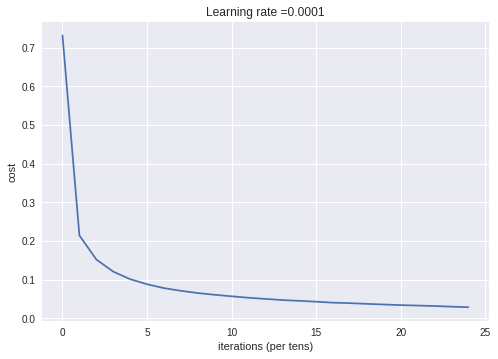

In [0]:
model(X_train, Y_train, X_test, Y_test,learning_rate = 0.0001,num_epochs = 25,
      minibatch_size = 64)